# Overfitting vs. Underfitting

Exploring a fundamental problem in modeling. This notebook will look at a simple example showing the problem of overfitting and underfitting as well as how to address it via cross-validation. This example is based on the [scikit-learn exercise](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html). 

## Imports 

We will use numpy and pandas, two of the most common libraries for data manipulation. We use scikit-learn, a popular machine learning library, for creating and evaluating the models. Matplotlib is used for model visualization.

In [1]:
# Numpy and pandas as usual
import numpy as np
import pandas as pd

# Scikit-Learn for fitting models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# For plotting in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [9, 7]

## Generate a relationship

First, we need a "true" relationship. We define a curve, in this case a sine curve to serve as our process that generates the data. As the real-world is never perfectly celan however, we also need to add some noise into the observations. This is done by adding a small random number to each value. 

In [2]:
# Set the random seed for reproducible results
np.random.seed(42)

# "True" generating function representing a process in real life
def true_gen(x):
    y = np.sin(1.2 * x * np.pi) 
    return(y)

# x values and y value with a small amount of random noise
x = np.sort(np.random.rand(120))
y = true_gen(x) + 0.1 * np.random.randn(len(x))

## Training and Testing Sets

In [3]:
# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(120)), size = 120, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations
train = xt[:int(0.7 * len(x))]
test = xt[int(0.7 * len(x)):]

y_train = yt[:int(0.7 * len(y))]
y_test = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_gen(x_linspace)

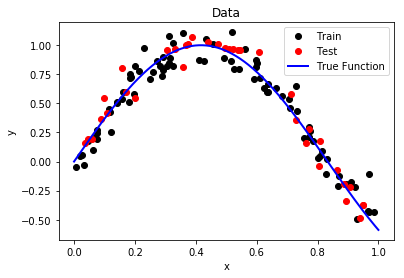

In [4]:
# Visualize observations and true curve
plt.plot(train, y_train, 'ko', label = 'Train'); 
plt.plot(test, y_test, 'ro', label = 'Test')
plt.plot(x_linspace, y_true, 'b-', linewidth = 2, label = 'True Function')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data');

# Polynomial Model

We want to try and capture the data using a polynomial function. A polynomial is defined by the degree, or the highest power to for the x-values. A line has a degree of 1 because it is of the form $y = b_1*x + b_0$ where $b_1$ is the slope and $b_0$ is the intercept. A third degree polynomial would have the form $y = b_3 * x^3 + b_2 * x^2 + b_1 * x + b_0$ and so on. The higher the degree of the polynomial, the more flexible the model. A more flexible model is prone to overfitting because it can can "bend" to follow the training data.  

The following function creates a polynomial with the specified number of degrees and plots the results. We can use these results to determine the optimal degrees to achieve the right balance between over and underfitting. 

In [5]:

def fit_poly(train, y_train, test, y_test, degrees, plot='train', return_scores=False):
    
    # Create a polynomial transformation of features
    features = PolynomialFeatures(degree=degrees, include_bias=False)
    
    # Reshape training features for use in scikit-learn and transform features
    train = train.reshape((-1, 1))
    train_trans = features.fit_transform(train)
    
    # Create the linear regression model and train
    model = LinearRegression()
    model.fit(train_trans, y_train)
    
    # Calculate the cross validation score
    cross_valid = cross_val_score(model, train_trans, y_train, scoring='neg_mean_squared_error', cv = 5)
    
    # Training predictions and error
    train_predictions = model.predict(train_trans)
    training_error = mean_squared_error(y_train, train_predictions)
    
    # Format test features
    test = test.reshape((-1, 1))
    test_trans = features.fit_transform(test)
    
    # Test set predictions and error
    test_predictions = model.predict(test_trans)
    testing_error = mean_squared_error(y_test, test_predictions)
    
    # Find the model curve and the true curve
    x_curve = np.linspace(0, 1, 100)
    x_curve = x_curve.reshape((-1, 1))
    x_curve_trans = features.fit_transform(x_curve)
    
    # Model curve
    model_curve = model.predict(x_curve_trans)
    
    # True curve
    y_true_curve = true_gen(x_curve[:, 0])
    
    # Plot observations, true function, and model predicted function
    if plot == 'train':
        plt.plot(train[:, 0], y_train, 'ko', label = 'Observations')
        plt.plot(x_curve[:, 0], y_true_curve, linewidth = 4, label = 'True Function')
        plt.plot(x_curve[:, 0], model_curve, linewidth = 4, label = 'Model Function')
        plt.xlabel('x'); plt.ylabel('y')
        plt.legend()
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.title('{} Degree Model on Training Data'.format(degrees))
        plt.show()
        
    elif plot == 'test':
        # Plot the test observations and test predictions
        plt.plot(test, y_test, 'o', label = 'Test Observations')
        plt.plot(x_curve[:, 0], y_true_curve, 'b-', linewidth = 2, label = 'True Function')
        plt.plot(test, test_predictions, 'ro', label = 'Test Predictions')
        plt.ylim(-1, 1.5); plt.xlim(0, 1)
        plt.legend(), plt.xlabel('x'), plt.ylabel('y'); plt.title('{} Degree Model on Testing Data'.format(degrees)), plt.show();
    
    # Return the metrics
    if return_scores:
        return training_error, testing_error, -np.mean(cross_valid)

## Try Model with Different Degrees

### Degrees = 1 -> Underfitting

In this case, a linear model cannot accurate learn the relationship between x and y and will underfit the data. 

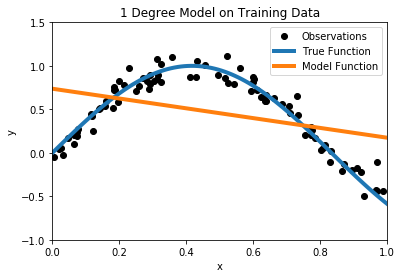

In [6]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='train')

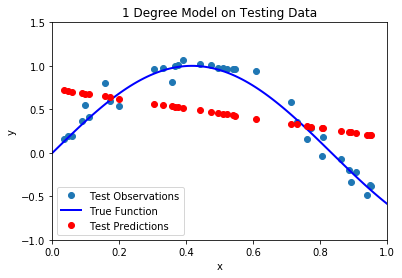

In [7]:
fit_poly(train, y_train, test, y_test, degrees = 1, plot='test')

## Degrees = 25 -> Overfitting

We can go in the completely opposite direction and create a model that overfits the data. This model has too much flexibility and learns the training data too closely. As the training data has some amount of noise, it will end up capturing that noise and will be misled by that noise when it tries to make predictions on the test data.

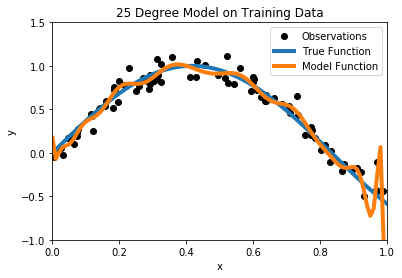

In [8]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 25)

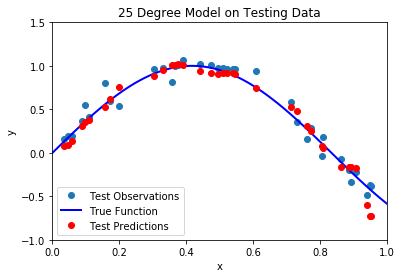

In [9]:
fit_poly(train, y_train, test, y_test, degrees=25, plot='test')

## Degrees = 5 -> Balanced Model

Now that we have seen the two extremes, we can take a look at a model that does a good job of both accounting for the data while not following it too closely. 

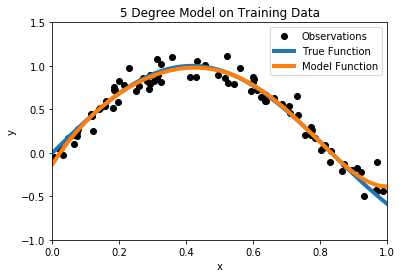

In [10]:
fit_poly(train, y_train, test, y_test, plot='train', degrees = 5)

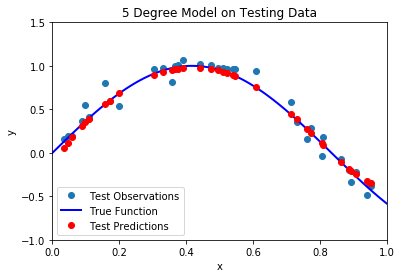

In [11]:
fit_poly(train, y_train, test, y_test, degrees=5, plot='test')

# Cross Validation

To pick the optimal model, we need to use a validation set. Cross validation is even better than a single validation set because it uses numerous validation sets created from the training data. In this case, we are using 5 different validation sets. The model that performs best on the cross validation is usually the optimal model because it has shown that it can learn the relationships while not overfitting.

In [14]:
# Range of model degrees to evaluate
degrees = [int(x) for x in np.linspace(1, 40, 40)]

# Results dataframe
results = pd.DataFrame(0, columns = ['train_error', 'test_error', 'cross_valid'], index = degrees)

# Try each value of degrees for the model and record results
for degree in degrees:
    degree_results = fit_poly(train, y_train, test, y_test, degree, plot=False, return_scores=True)
    results.loc[degree, 'train_error'] = degree_results[0]
    results.loc[degree, 'test_error'] = degree_results[1]
    results.loc[degree, 'cross_valid'] = degree_results[2]

In [17]:
print('10 Lowest Cross Validation Errors\n')
train_eval = results.sort_values('cross_valid').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'cross_valid']] .head(10)

10 Lowest Cross Validation Errors



,degrees,cross_valid
0,4,0.010549
1,5,0.010637
2,7,0.010665
3,6,0.010887
4,8,0.011182
5,3,0.011695
6,9,0.011757
7,11,0.011769
8,10,0.011902
9,12,0.012642


Minimum Cross Validation Error occurs at 3 degrees.



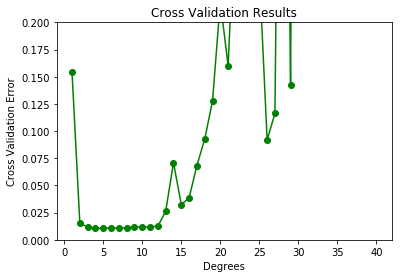

In [16]:
plt.plot(results.index, results['cross_valid'], 'go-', ms=6)
plt.xlabel('Degrees'); plt.ylabel('Cross Validation Error'); plt.title('Cross Validation Results');
plt.ylim(0, 0.2);
print('Minimum Cross Validation Error occurs at {} degrees.\n'.format(int(np.argmin(results['cross_valid']))))

# Final Model

The model with the lowest cross validation error had four degrees. Therefore, we will use a 4th degree polynomial for the final model. 

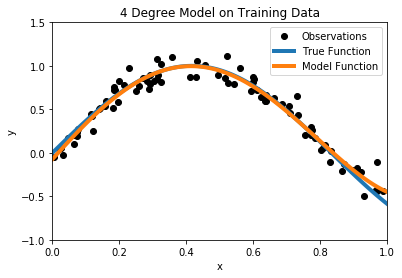

In [18]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='train')

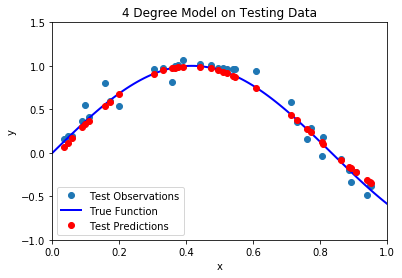

In [19]:
fit_poly(train, y_train, test, y_test, degrees=4, plot='test')

## Evaluate Models 

The next step is to examine the scores for the models. We will use a range of values to see how the performance on the training and testing set compares. A model with much lower errors on the training data than the testing data is overfit. A model with high error on the training data (which will lead to high testing error as well) is underfitting because it does not even learn the training data. 

#### Quantitative Comparison

In [22]:
print('10 Lowest Training Errors\n')
train_eval = results.sort_values('train_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'train_error']] .head(10)

10 Lowest Training Errors



,degrees,train_error
0,36,0.006137
1,35,0.006151
2,40,0.006213
3,39,0.006269
4,31,0.006359
5,27,0.006406
6,32,0.006416
7,28,0.006430
8,33,0.006442
9,29,0.006468


In [23]:
print('10 Lowest Testing Errors\n')
train_eval = results.sort_values('test_error').reset_index(level=0).rename(columns={'index': 'degrees'})
train_eval.loc[:,['degrees', 'test_error']] .head(10)

10 Lowest Testing Errors



,degrees,test_error
0,5,0.009482
1,6,0.010215
2,4,0.010483
3,8,0.010609
4,7,0.010618
5,9,0.010754
6,14,0.011216
7,10,0.011321
8,11,0.011342
9,13,0.011387


#### Visual Comparison

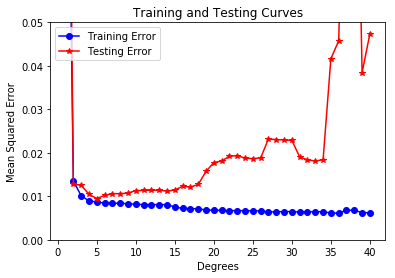


Minimum Training Error occurs at 35 degrees.
Minimum Testing Error occurs at 4 degrees.



In [24]:
plt.plot(results.index, results['train_error'], 'b-o', ms=6, label = 'Training Error')
plt.plot(results.index, results['test_error'], 'r-*', ms=6, label = 'Testing Error')
plt.legend(loc=2); plt.xlabel('Degrees'); plt.ylabel('Mean Squared Error'); plt.title('Training and Testing Curves');
plt.ylim(0, 0.05); plt.show()

print('\nMinimum Training Error occurs at {} degrees.'.format(int(np.argmin(results['train_error']))))
print('Minimum Testing Error occurs at {} degrees.\n'.format(int(np.argmin(results['test_error']))))